# Feature extraction from preprocessed data
Relevant features are extracted directly from the relations data

In [2]:
import numpy as np
import pandas as pd
import csv
from matplotlib import pyplot as plt
import time
import sys
import os
import subprocess
import datetime
import math
import timeit

def restart_line():
    sys.stdout.write('\r')
    sys.stdout.flush()

filenames =['relations_extended.csv','relations_red_ext.csv']

path = "/Users/jonasmuller/Local_Folder/Project NTDS/"
file = path + filenames[1]

# using dataset without timestamps
reducedDataset = True
if reducedDataset:
    columns=["src", "dst","relation"]
else:
    columns=["day", "time_ms", "src", "dst","relation"]
    
rel_stat = np.array([[1,0.006714],[2,0.010907],[3,0.162401],[4,0.235368],[5,0.175797],[6,0.408653],[7,0.000160]])

entropy = -rel_stat[:,1]*np.log2(rel_stat[:,1])
inv_weight = 1/rel_stat[:,1]
inv_weight /= sum(inv_weight)
weight_dict = dict(zip(rel_stat[:,0], inv_weight))
weight_dict_in = dict(zip(rel_stat[:,0]+10, inv_weight))
w_min = np.min(inv_weight)

In [20]:
chunksize = 4000000
i_chunk = 0
L = 1000000000
l = 0

# select execution mode
calc_stat = False
debug = False
save_features = True
save_bidirect_rel = True
bidirectionality = True
spare_deg_one = False
find_unique_neigh = True
weights = True

# initialize shit
carry = pd.DataFrame()
df_buffer = pd.DataFrame()
features = pd.DataFrame()
rel_dist = pd.DataFrame(np.zeros(7),list(range(1,8)),columns=["count"])
if save_bidirect_rel:
    relations_bidirect = np.zeros((L,2),dtype=np.uint32)
t1 = time.time()
told = t1
n_chunks = np.ceil(1716494198/chunksize).astype(np.uint32)
print(f"Number of Chunks: {n_chunks:}")
t_chunk = np.zeros([n_chunks])

for chunk in pd.read_csv(file, chunksize=chunksize, sep = "\t", names=columns):
    
    # slice chunk at specific src
    chunk = carry.append(chunk)
    
    # remove last source in chunk
    last_src = chunk["src"].iloc[-1]
    carry = chunk.loc[chunk["src"] == last_src]
    chunk = chunk.loc[chunk["src"] != last_src]
    
    # extract features        
    degree_tot = chunk.groupby('src').dst.count()
    degree_out = chunk.loc[chunk["relation"] < 10].groupby('src').dst.count()
    
    
    # put aside calculations for degree 1 nodes
    if spare_deg_one:
        a = np.diff(chunk.src.to_numpy())
        a[a > 0] = 1
        a = np.convolve(a, [1,1], mode='same')
        a[a < 2] = 0
        single_deg_ind = np.asarray(np.nonzero(a)).squeeze() + chunk.index[0]

        chunk.drop(single_deg_ind)
    
    # find number of unique neighbors
    if find_unique_neigh:
        unique_neighbors = chunk.groupby('src').dst.nunique()
    
    # check bidirectionality
    if bidirectionality:
        chunk_copy = chunk.copy()
        chunk_copy["relation"] = (chunk_copy["relation"] >= 10).astype(int)
        bidirect = chunk_copy.groupby(['src','dst']).max() - chunk_copy.groupby(['src','dst']).min()
        nr_of_bidirect = bidirect.groupby('src').relation.sum()
        if save_bidirect_rel:
            bidirect = bidirect.loc[bidirect['relation'] == 1].drop('relation', 1).reset_index()
            # remove duplicate relations and self-loops
            bidirect = bidirect[np.diff(bidirect.to_numpy()) > 0]
    
    # weights acording to relation scarcity (then deg in deg out) / number of strong connections per node
    if weights:
        chunk_copy = chunk.copy()
        w_out = chunk_copy.loc[chunk["relation"] < 10].replace({'relation': weight_dict}).groupby('src').relation.sum()
        w_in = chunk_copy.loc[chunk["relation"] >= 10].replace({'relation': weight_dict_in}).groupby('src').relation.sum()
        w_out = (10*(np.log(w_out)-np.log(w_min))).astype(int)
        w_in = (10*(np.log(w_in)-np.log(w_min))).astype(int)
            
    # relation distribution count
    if calc_stat:
        values, counts = np.unique(chunk.loc[chunk["relation"] < 10].relation.values, return_counts=True)
        rel_dist = rel_dist.add(pd.Series(counts, index=values),axis='index')
    
    # append degrees
    df_buffer = df_buffer[0:0]
    df_buffer['deg_tot'] = pd.Series(degree_tot)
    df_buffer['deg_out'] = pd.Series(degree_out)
    df_buffer['u_neigh'] = pd.Series(unique_neighbors)
    df_buffer['n_bidir'] = pd.Series(nr_of_bidirect)
    df_buffer['w_out'] = pd.Series(w_out)
    df_buffer['w_in'] = pd.Series(w_in)
    
    df_buffer = df_buffer.fillna(0)
    
    features = features.append(df_buffer.astype('uint32'))
    
    if save_bidirect_rel:
        l2 = len(bidirect)
        relations_bidirect[l:(l+l2),:] = bidirect.to_numpy()
        if l2 >= 0:
            l += l2+1
    
    # break for debugging
    if debug:
        if i_chunk > 1:
            break
    
    # print status
    s = (time.time()-told)
    told = time.time()
    t_chunk[i_chunk] = s

    restart_line()
    sys.stdout.write(f'Chunk Nr: {i_chunk}; \t feature shape: {features.shape} \t tc: {s:.2f} sec')
    sys.stdout.flush()
    i_chunk += 1

if save_bidirect_rel:
    relations_bidirect = relations_bidirect[0:(l-1),:]

# print relevant key data
m = math.floor((time.time()-t1)/60)
s = (time.time()-t1)-m*60
print(f'\n\nExecution time {m} min {s:.2f} sec')

# statistics
total_relations = np.sum(rel_dist.values)
rel_dist = rel_dist.div(total_relations)
with open("Output.txt", "w") as text_file:
    print(f"Nr of total relations: {total_relations}\n", file=text_file)
    print("Relations Distribution:\n", file=text_file)
    print(rel_dist, file=text_file)

# save features
if save_features:
    exportName = "relations_features.csv"
    features.to_csv(exportName, sep = '\t')
    if save_bidirect_rel:
        np.savetxt("relations_bidirectional.csv", relations_bidirect, fmt='%i', delimiter="\t")
    

Number of Chunks: 430
Chunk Nr: 429; 	 feature shape: (5321960, 6) 	 tc: 0.69 sec

Execution time 38 min 40.02 sec


deg_tot    uint32
deg_out    uint32
u_neigh    uint32
n_bidir    uint32
w_out      uint32
w_in       uint32
dtype: object

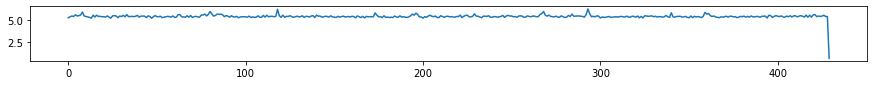

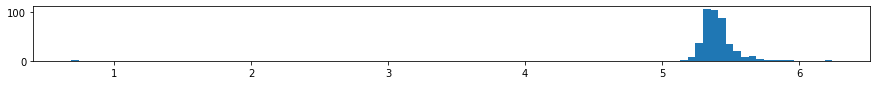

In [21]:
# visualize
ax = plt.figure(1, figsize=(15, 1))
plt.plot(t_chunk);
ax = plt.figure(2, figsize=(15, 1))
plt.hist(t_chunk, bins=100);

In [ ]:
relations_bidirect.to_csv('relations_bidirectional.csv', sep = '\t')

In [ ]:
rel_bidir = pd.read_csv('relations_bidirectional.csv', sep = "\t").to_numpy()

In [ ]:
rel_bidir_sub = rel_bidir[::10,:]
nodes = np.unique(rel_bidir_sub)

# replace node numbers


In [ ]:
nodes, counts = np.unique(rel_bidir,return_counts=True)

In [ ]:
A = np.asarray([nodes, counts-1]).T

A_sub = A[::10,:]
a = len(A_sub)
# remove nodes with only one occurence
#A = A[A[:,1] > 150,:]
print(a)
print(len(A))

#A[A[:,1] >= 500,1] = 500

bins=np.logspace(np.log10(1),np.log10(1000),100)
ax = plt.figure(1, figsize=(15, 3))
plt.hist(A[:,1],log=True,bins=bins)
plt.gca().set_xscale("log")
plt.show()

print(len(A))
bins=np.logspace(np.log10(0.1),np.log10(1000),200)
#np.savetxt("relations_bidirectional_reduced.csv", A, fmt='%i', delimiter="\t")

#A_red = rel_bidir[]